In [1]:
# %matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math

In [2]:
def h(x):
    r = np.sqrt((x[0]+75)**2+(x[1]+50)**2)
    theta = np.arctan2(x[1]+50,x[0]+75)
    return np.array([r,theta]).transpose()

In [3]:
def dr_dx(data):
    x = data[0] +75 
    y = data[1] +50
    return x/np.sqrt(x**2+y**2)

In [4]:
def dr_dy(data):
    x = data[0] + 75
    y = data[1] + 50
    return y/np.sqrt(x**2+y**2)

In [5]:
def dtheta_dx(data):
    x = data[0] + 75
    y = data[1] +50
    return -y/(x**2+y**2)

In [6]:
def dtheta_dy(data):
    x = data[0] + 75
    y = data[1] + 50
    return x/(x**2+y**2)

In [7]:
def ek(x,z,R):
    hx = h(x)
    res = (hx-z)@(np.linalg.inv(R))@(hx-z).transpose()
    #print(res)
    return res

In [8]:
def J(x):
    res = np.zeros((2,2))
    res[0,0] = dr_dx(x)
    res[0,1] = dr_dy(x)
    res[1,0] = dtheta_dx(x)
    res[1,1] = dtheta_dy(x)      
    return res

In [9]:
def F(X,Z,R):
    e_1k = [ek(X[i,:],Z[i,:],R) for i in range(X.shape[0])]
    F_sum = np.sum(e_1k)
    return F_sum
def F2(X, Z1, Z2, R1, R2):
    x_hat = X
    z_hat_k = h(x_hat)
    z_k1 = Z1
    z_k2 = Z2
    e_k1  = z_hat_k - z_k1
    e_k2 = z_hat_k - z_k2
    angle = e_k1[1]
    e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
    angle = e_k2[1]
    e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
    return (0.5*e_k1.transpose()@R1@e_k1) + (0.5*e_k2.transpose()@R2@e_k2)

In [10]:
def get_xy(r,theta):
    x = r*np.cos(theta) -75
    y = r*np.sin(theta) -50
    return np.array([x, y])

In [11]:
def GaussNewtwonMinimization(X_init,Z1,Z2,R1,R2):
    F_new = (F(X_init,Z1,R1)+F(X_init,Z2,R2))/2
    print(F_new)
    F_hat = F_new
    X_hat = X_init.copy()
    K = Z1.shape[0]
    R1_inv = np.linalg.inv(R1)
    R2_inv = np.linalg.inv(R2)
    F2(X_init[0,:], Z1[0,:], Z2[0,:], R1_inv, R2_inv)
    max_itr = 0
    count = 0
    alpha = 0.5
    beta = 0.5
    eps = 1e-8
    while(True):
        F_hat = F_new
        b = np.zeros(2*K)
        H = np.zeros((2*K,2*K))
        for k in range(K):
            x_hat = X_hat[k,:]
            z_hat_k = h(x_hat)
            z_k1 = Z1[k,:]
            z_k2 = Z2[k,:]
            e_k1  = z_hat_k - z_k1
            e_k2 = z_hat_k-z_k2
            angle = e_k1[1]
            e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
            angle = e_k2[1]
            e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
            if(count == max_itr -1 ):
                pass
                #print(z_hat_k, z_k1,x_hat)
            J_k = J(x_hat)
            H_k = (J_k.transpose()@(R1_inv)@J_k)+(J_k.transpose()@(R2_inv)@J_k)
            b_k = (J_k.transpose()@R1_inv@e_k1)+(J_k.transpose()@R2_inv@e_k2)
            
            delta_X_k =  np.linalg.pinv(H_k)@b_k
            itr = 0
            alpha = 0.5
            beta = 0.99
            t= 0.01
            while((np.linalg.norm(b_k)) > eps) and (itr < 10):
                t=1
                itr+=1
               # print(x_hat - t*delta_X_k)
                while F2(x_hat - t*delta_X_k, Z1[k,:], Z2[k,:], R1_inv, R2_inv) > F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)-alpha*t*b_k.transpose()@delta_X_k :
                    t = beta*t
                print("got t: ",t)
                print("norm grad: ", np.linalg.norm(b_k))
                print(f"cost for point {k} before iter: {itr} : {F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)}")
                x_hat = x_hat - t*delta_X_k
                #t = 0.5*t
                print(f"cost for point {k}, iter: {itr} : {F2(x_hat, Z1[k,:], Z2[k,:], R1_inv, R2_inv)}")
                z_hat_k = h(x_hat)
                z_k1 = Z1[k,:]
                z_k2 = Z2[k,:]
                e_k1  = z_hat_k - z_k1
                e_k2 = z_hat_k-z_k2
                angle = e_k1[1]
                e_k1[1] = (angle + math.pi) % (2 * math.pi) - math.pi
                angle = e_k2[1]
                e_k2[1] = (angle + math.pi) % (2 * math.pi) - math.pi
                J_k = J(x_hat)
                H_k = (J_k.transpose()@(R1_inv)@J_k)+(J_k.transpose()@(R2_inv)@J_k)
                print("printing Hk: ", H_k)
                b_k = (J_k.transpose()@R1_inv@e_k1)+(J_k.transpose()@R2_inv@e_k2)
                delta_X_k = np.linalg.pinv(H_k)@b_k
            #delta_X_k = -0.01*b_k
            #x_hat += delta_X_k
            X_hat[k,:] = x_hat
            itr = itr + 1
        F_new = (F(X_hat,Z1,R1)+F(X_hat,Z2,R2))/2
        #print(F_new,(F_hat-F_new))
        #print(H)
        count +=1
        #if np.abs(F_hat-F_new)<5:
        if count>max_itr:
            break
    return X_hat,F_new

In [12]:
data1 = pd.read_csv('./gauss_noise1_rt.csv')
data2 = pd.read_csv('./gauss_noise2_rt.csv')
gt_data = pd.read_csv('./ground_truth.csv')
data1 = data1.to_numpy()
data2 = data2.to_numpy()
gt_data = gt_data.to_numpy()

In [13]:
Z1 = data1[:,2:4]
Z2 = data2[:,2:4]
X_init1 = get_xy(Z1[:,0], Z1[:,1])
X_init2 = get_xy(Z2[:,0], Z2[:,1])
X1_init = (X_init1.transpose()*0.5+X_init2.transpose()*0.5)
R1=np.diag([0.01,0.04])
R2=np.diag([16,0.0004])

In [14]:
X1_hat,F_new = GaussNewtwonMinimization(X1_init,Z1,Z2,R1,R2)

205272.36217276825
got t:  0.8179069375972307
norm grad:  91.8897095083914
cost for point 0 before iter: 1 : 70.13376425741717
cost for point 0, iter: 1 : 12.82212334428735
printing Hk:  [[73.74876741 43.96062478]
 [43.96062478 26.62037148]]
got t:  0.99
norm grad:  46.32607854466756
cost for point 0 before iter: 2 : 12.82212334428735
cost for point 0, iter: 2 : 1.1820134799338202
printing Hk:  [[71.25316836 45.20883959]
 [45.20883959 29.11884874]]
got t:  0.99
norm grad:  4.002912475206618
cost for point 0 before iter: 3 : 1.1820134799338202
cost for point 0, iter: 3 : 1.101927725223474
printing Hk:  [[71.24005617 45.21486094]
 [45.21486094 29.13223253]]
got t:  1
norm grad:  0.04012524143047271
cost for point 0 before iter: 4 : 1.101927725223474
cost for point 0, iter: 4 : 1.101919677578438
printing Hk:  [[71.23992956 45.21491902]
 [45.21491902 29.13236189]]
got t:  0.99
norm grad:  251.93043825456618
cost for point 1 before iter: 1 : 320.59829270857153
cost for point 1, iter: 1 : 1.

got t:  0.99
norm grad:  5.068997602024823e-06
cost for point 24 before iter: 5 : 0.044920948037771934
cost for point 24, iter: 5 : 0.044920948037640955
printing Hk:  [[70.22643013 45.67311022]
 [45.67311022 30.14601949]]
got t:  1
norm grad:  5.069120211446476e-08
cost for point 24 before iter: 6 : 0.044920948037640955
cost for point 24, iter: 6 : 0.044920948037640296
printing Hk:  [[70.22643013 45.67311022]
 [45.67311022 30.14601949]]
got t:  0.5870367819374844
norm grad:  28.079043469807154
cost for point 25 before iter: 1 : 58.704069559283596
cost for point 25, iter: 1 : 25.5190729847532
printing Hk:  [[63.15305908 48.16257715]
 [48.16257715 37.21587377]]
got t:  0.7547192872036325
norm grad:  52.628462590956275
cost for point 25 before iter: 2 : 25.5190729847532
cost for point 25, iter: 2 : 8.139460552460688
printing Hk:  [[69.21533462 46.10423436]
 [46.10423436 31.15502019]]
got t:  0.99
norm grad:  31.579383566614435
cost for point 25 before iter: 3 : 8.139460552460688
cost for 

got t:  0.8775210229989678
norm grad:  451.1723181550284
cost for point 51 before iter: 1 : 1109.4097800393415
cost for point 51, iter: 1 : 124.73052086437508
printing Hk:  [[70.70982863 45.45247791]
 [45.45247791 29.67954503]]
got t:  0.99
norm grad:  153.79630980205025
cost for point 51 before iter: 2 : 124.73052086437508
cost for point 51, iter: 2 : 4.404711201256817
printing Hk:  [[74.89450805 43.31794163]
 [43.31794163 25.50573477]]
got t:  0.99
norm grad:  11.121515446025477
cost for point 51 before iter: 3 : 4.404711201256817
cost for point 51, iter: 3 : 3.7865958576402114
printing Hk:  [[74.86782899 43.33288939]
 [43.33288939 25.53327506]]
got t:  0.99
norm grad:  0.11163141340326344
cost for point 51 before iter: 4 : 3.7865958576402114
cost for point 51, iter: 4 : 3.786533585502931
printing Hk:  [[74.8675964  43.33301927]
 [43.33301927 25.53351631]]
got t:  1
norm grad:  0.0011163458400947042
cost for point 51 before iter: 5 : 3.786533585502931
cost for point 51, iter: 5 : 3.7

got t:  0.99
norm grad:  17.373276778635546
cost for point 77 before iter: 2 : 2.338679974276589
cost for point 77, iter: 2 : 0.40687678020496765
printing Hk:  [[97.92508577 14.4371052 ]
 [14.4371052   2.54747301]]
got t:  0.99
norm grad:  1.5104225329065117
cost for point 77 before iter: 3 : 0.40687678020496765
cost for point 77, iter: 3 : 0.3954507202495486
printing Hk:  [[97.92086189 14.45103862]
 [14.45103862  2.55185311]]
got t:  0.99
norm grad:  0.015188272388234739
cost for point 77 before iter: 4 : 0.3954507202495486
cost for point 77, iter: 4 : 0.39544956502412215
printing Hk:  [[97.92082044 14.45117529]
 [14.45117529  2.55189613]]
got t:  1
norm grad:  0.00015189081269799387
cost for point 77 before iter: 5 : 0.39544956502412215
cost for point 77, iter: 5 : 0.39544956490857586
printing Hk:  [[97.92082002 14.45117667]
 [14.45117667  2.55189657]]
got t:  0.96059601
norm grad:  97.69144753222112
cost for point 78 before iter: 1 : 55.59891643429391
cost for point 78, iter: 1 : 1.

printing Hk:  [[ 90.14493347 -29.83933104]
 [-29.83933104  10.28385575]]
got t:  0.9801
norm grad:  257.6171218890252
cost for point 102 before iter: 1 : 346.6197763458854
cost for point 102, iter: 1 : 7.740117487399004
printing Hk:  [[ 89.303308   -30.93465308]
 [-30.93465308  11.11969078]]
got t:  0.99
norm grad:  36.32234837222154
cost for point 102 before iter: 2 : 7.740117487399004
cost for point 102, iter: 2 : 1.1102471282128783
printing Hk:  [[ 88.96042403 -31.36253545]
 [-31.36253545  11.46567967]]
got t:  0.99
norm grad:  0.4897720776468255
cost for point 102 before iter: 3 : 1.1102471282128783
cost for point 102, iter: 3 : 1.109047341200646
printing Hk:  [[ 88.95845317 -31.36496274]
 [-31.36496274  11.46769282]]
got t:  1
norm grad:  0.004901855902045142
cost for point 102 before iter: 4 : 1.109047341200646
cost for point 102, iter: 4 : 1.1090472210089013
printing Hk:  [[ 88.95843338 -31.36498711]
 [-31.36498711  11.46771304]]
got t:  0.99
norm grad:  304.6315739921229
cost f

got t:  0.99
norm grad:  198.9552303978531
cost for point 131 before iter: 1 : 198.74356216319316
cost for point 131, iter: 1 : 0.5879737999887903
printing Hk:  [[ 62.19534225 -48.41808984]
 [-48.41808984  38.1536702 ]]
got t:  0.99
norm grad:  3.623992029869116
cost for point 131 before iter: 2 : 0.5879737999887903
cost for point 131, iter: 2 : 0.5223062555794992
printing Hk:  [[ 62.21426817 -48.41330155]
 [-48.41330155  38.13496326]]
got t:  0.99
norm grad:  0.03641770192602961
cost for point 131 before iter: 3 : 0.5223062555794992
cost for point 131, iter: 3 : 0.5222996246402289
printing Hk:  [[ 62.21445023 -48.41325542]
 [-48.41325542  38.13478341]]
got t:  1
norm grad:  0.0003641934645566223
cost for point 131 before iter: 4 : 0.5222996246402289
cost for point 131, iter: 4 : 0.5222996239770091
printing Hk:  [[ 62.21445206 -48.41325495]
 [-48.41325495  38.13478159]]
got t:  0.99
norm grad:  396.7950693318233
cost for point 132 before iter: 1 : 794.5539066942011
cost for point 132, 

got t:  0.7778213593991465
norm grad:  38.05288274486726
cost for point 158 before iter: 1 : 30.766175655116168
cost for point 158, iter: 1 : 7.547444872467591
printing Hk:  [[ 35.60085486 -47.61922846]
 [-47.61922846  64.88513346]]
got t:  0.9801
norm grad:  32.94878327538999
cost for point 158 before iter: 2 : 7.547444872467591
cost for point 158, iter: 2 : 1.0352098793813775
printing Hk:  [[ 32.76864221 -46.6520796 ]
 [-46.6520796   67.72052107]]
got t:  0.99
norm grad:  4.132144697918969
cost for point 158 before iter: 3 : 1.0352098793813775
cost for point 158, iter: 3 : 0.9495955421135169
printing Hk:  [[ 32.72354622 -46.63483411]
 [-46.63483411  67.76607081]]
got t:  0.99
norm grad:  0.042232617175365285
cost for point 158 before iter: 4 : 0.9495955421135169
cost for point 158, iter: 4 : 0.9495866033688725
printing Hk:  [[ 32.72311953 -46.63467045]
 [-46.63467045  67.76650213]]
got t:  1
norm grad:  0.00042240786358960225
cost for point 158 before iter: 5 : 0.9495866033688725
cos

got t:  1
norm grad:  0.7082232319391935
cost for point 184 before iter: 3 : 4.077832089527673
cost for point 184, iter: 3 : 4.075325754013605
printing Hk:  [[ 3.01623173 15.23173943]
 [15.23173943 97.67182707]]
got t:  0.9043820750088043
norm grad:  130.44317085849363
cost for point 185 before iter: 1 : 113.28418313335708
cost for point 185, iter: 1 : 10.091457517251223
printing Hk:  [[ 2.72526422 14.32931296]
 [14.32931296 97.9530379 ]]
got t:  0.99
norm grad:  41.43505821621616
cost for point 185 before iter: 2 : 10.091457517251223
cost for point 185, iter: 2 : 1.1478634288445677
printing Hk:  [[ 2.26833787 12.68258385]
 [12.68258385 98.41773993]]
got t:  0.99
norm grad:  1.355746623355687
cost for point 185 before iter: 3 : 1.1478634288445677
cost for point 185, iter: 3 : 1.1386746720804173
printing Hk:  [[ 2.26698406 12.67643663]
 [12.67643663 98.41935671]]
got t:  0.99
norm grad:  0.013570333928667962
cost for point 185 before iter: 4 : 1.1386746720804173
cost for point 185, iter

got t:  0.6111172395328651
norm grad:  68.72959119406315
cost for point 211 before iter: 1 : 50.48516482660234
cost for point 211, iter: 1 : 20.222500033983394
printing Hk:  [[38.07350373 48.28461357]
 [48.28461357 62.45253616]]
got t:  0.9509900498999999
norm grad:  54.841026474877985
cost for point 211 before iter: 2 : 20.222500033983394
cost for point 211, iter: 2 : 2.213671714656323
printing Hk:  [[43.22902252 49.29715549]
 [49.29715549 57.30232331]]
got t:  0.99
norm grad:  12.901083362184606
cost for point 211 before iter: 3 : 2.213671714656323
cost for point 211, iter: 3 : 1.375006535228561
printing Hk:  [[43.46256718 49.32899085]
 [49.32899085 57.0704112 ]]
got t:  0.99
norm grad:  0.14939857145729973
cost for point 211 before iter: 4 : 1.375006535228561
cost for point 211, iter: 4 : 1.374894529595835
printing Hk:  [[43.46450063 49.3292466 ]
 [49.3292466  57.06849673]]
got t:  1
norm grad:  0.0014953776177021813
cost for point 211 before iter: 5 : 1.374894529595835
cost for poi

 [47.92997274 37.02717176]]
got t:  1
norm grad:  0.002674892887192612
cost for point 236 before iter: 4 : 1.24666207689399
cost for point 236, iter: 4 : 1.2466620409954605
printing Hk:  [[63.61810606 47.92998157]
 [47.92998157 37.02720471]]
got t:  0.8429431933839266
norm grad:  26.462396995270666
cost for point 237 before iter: 1 : 17.5730406606149
cost for point 237, iter: 1 : 3.0455011256098414
printing Hk:  [[63.8480494  47.86321904]
 [47.86321904 36.80356058]]
got t:  0.99
norm grad:  20.65827331376895
cost for point 237 before iter: 2 : 3.0455011256098414
cost for point 237, iter: 2 : 0.5644238682565691
printing Hk:  [[65.43977206 47.38337959]
 [47.38337959 35.21536648]]
got t:  0.99
norm grad:  1.1168987483618504
cost for point 237 before iter: 3 : 0.5644238682565691
cost for point 237, iter: 3 : 0.558173726212783
printing Hk:  [[65.45087558 47.37976356]
 [47.37976356 35.20446366]]
got t:  1
norm grad:  0.011213249521660782
cost for point 237 before iter: 4 : 0.558173726212783


got t:  0.9801
norm grad:  211.0469033525563
cost for point 265 before iter: 1 : 232.49793842056155
cost for point 265, iter: 1 : 4.0009122169237745
printing Hk:  [[88.90707959 31.34398162]
 [31.34398162 11.99363775]]
got t:  0.99
norm grad:  24.167332948912996
cost for point 265 before iter: 2 : 4.0009122169237745
cost for point 265, iter: 2 : 1.0808328510379277
printing Hk:  [[88.83089656 31.43590821]
 [31.43590821 12.07717093]]
got t:  0.99
norm grad:  0.245786983677316
cost for point 265 before iter: 3 : 1.0808328510379277
cost for point 265, iter: 3 : 1.0805309524699565
printing Hk:  [[88.83046976 31.43641579]
 [31.43641579 12.07767298]]
got t:  1
norm grad:  0.0024580008764439267
cost for point 265 before iter: 4 : 1.0805309524699565
cost for point 265, iter: 4 : 1.080530922273915
printing Hk:  [[88.83046547 31.43642089]
 [31.43642089 12.07767803]]
got t:  0.9801
norm grad:  94.31452323115556
cost for point 266 before iter: 1 : 51.56425449493439
cost for point 266, iter: 1 : 1.04

got t:  0.5989560064661611
norm grad:  45.58010879396603
cost for point 294 before iter: 1 : 54.91727397184996
cost for point 294, iter: 1 : 23.035487458908786
printing Hk:  [[ 77.18004326 -41.81716443]
 [-41.81716443  23.64259191]]
got t:  0.92274469442792
norm grad:  53.10392973789483
cost for point 294 before iter: 2 : 23.035487458908786
cost for point 294, iter: 2 : 3.7075652169635314
printing Hk:  [[ 82.64104358 -37.76665527]
 [-37.76665527  18.1910298 ]]
got t:  0.99
norm grad:  17.533713633292997
cost for point 294 before iter: 3 : 3.7075652169635314
cost for point 294, iter: 3 : 2.1375541159070344
printing Hk:  [[ 83.03161829 -37.42880933]
 [-37.42880933  17.80511649]]
got t:  0.99
norm grad:  0.2520901646784549
cost for point 294 before iter: 4 : 2.1375541159070344
cost for point 294, iter: 4 : 2.1372349257443295
printing Hk:  [[ 83.0343385  -37.42642355]
 [-37.42642355  17.80246392]]
got t:  1
norm grad:  0.0025246419265523867
cost for point 294 before iter: 5 : 2.13723492574

 [-46.61394851  67.83722421]]
got t:  1
norm grad:  0.010233389604578227
cost for point 321 before iter: 4 : 2.6664607126284694
cost for point 321, iter: 4 : 2.6664601891991184
printing Hk:  [[ 32.6353299  -46.61395997]
 [-46.61395997  67.83719288]]
got t:  0.536268225207185
norm grad:  108.09671111126082
cost for point 322 before iter: 1 : 99.48255567324213
cost for point 322, iter: 1 : 47.26144579119968
printing Hk:  [[ 36.76222214 -47.97728359]
 [-47.97728359  63.69899863]]
got t:  0.8953382542587163
norm grad:  85.57045352326067
cost for point 322 before iter: 2 : 47.26144579119968
cost for point 322, iter: 2 : 7.023538682353499
printing Hk:  [[ 29.9294613  -45.50479659]
 [-45.50479659  70.53737815]]
got t:  0.99
norm grad:  30.013816368458738
cost for point 322 before iter: 3 : 7.023538682353499
cost for point 322, iter: 3 : 2.445338930655397
printing Hk:  [[ 29.22029533 -45.17932195]
 [-45.17932195  71.24957498]]
got t:  0.99
norm grad:  0.5424627914063974
cost for point 322 befo

cost for point 351 before iter: 4 : 0.047975704240559254
cost for point 351, iter: 4 : 0.04797570359647716
printing Hk:  [[ 11.48340667 -31.21479065]
 [-31.21479065  89.06257757]]
got t:  0.99
norm grad:  3.5696572502088225e-06
cost for point 351 before iter: 5 : 0.04797570359647716
cost for point 351, iter: 5 : 0.04797570359641276
printing Hk:  [[ 11.48340663 -31.21479059]
 [-31.21479059  89.06257762]]
got t:  1
norm grad:  3.569668240641687e-08
cost for point 351 before iter: 6 : 0.04797570359641276
cost for point 351, iter: 6 : 0.047975703596412754
printing Hk:  [[ 11.48340663 -31.21479059]
 [-31.21479059  89.06257762]]
got t:  0.9509900498999999
norm grad:  275.5828703156856
cost for point 352 before iter: 1 : 397.68690314617965
cost for point 352, iter: 1 : 19.099847837290778
printing Hk:  [[ 11.40395937 -31.12356101]
 [-31.12356101  89.13658082]]
got t:  0.99
norm grad:  58.334362260137176
cost for point 352 before iter: 2 : 19.099847837290778
cost for point 352, iter: 2 : 2.0922

cost for point 376 before iter: 4 : 2.001878954995655
cost for point 376, iter: 4 : 2.001878942847303
printing Hk:  [[ 0.72218433 -3.99611196]
 [-3.99611196 99.90175045]]
got t:  0.7936142836436553
norm grad:  173.39906020447975
cost for point 377 before iter: 1 : 233.70087247803428
cost for point 377, iter: 1 : 49.68239272845031
printing Hk:  [[ 0.96158033  6.40912192]
 [ 6.40912192 99.64800492]]
got t:  0.9801
norm grad:  91.65013529716728
cost for point 377 before iter: 2 : 49.68239272845031
cost for point 377, iter: 2 : 4.253621903583175
printing Hk:  [[  0.56389855   0.62871546]
 [  0.62871546 100.05852725]]
got t:  0.99
norm grad:  13.225418122615368
cost for point 377 before iter: 3 : 4.253621903583175
cost for point 377, iter: 3 : 3.379427617301673
printing Hk:  [[  0.56552896   0.58289305]
 [  0.58289305 100.05908518]]
got t:  1
norm grad:  0.13296497527782378
cost for point 377 before iter: 4 : 3.379427617301673
cost for point 377, iter: 4 : 3.3793392564901614
printing Hk:  [

got t:  0.99
norm grad:  338.63084864449297
cost for point 401 before iter: 1 : 574.4487396791394
cost for point 401, iter: 1 : 1.490176063642567
printing Hk:  [[27.32708852 44.24572555]
 [44.24572555 73.14735387]]
got t:  0.99
norm grad:  3.3357198434206823
cost for point 401 before iter: 2 : 1.490176063642567
cost for point 401, iter: 2 : 1.4345315951836
printing Hk:  [[27.30944399 44.23687029]
 [44.23687029 73.1646513 ]]
got t:  1
norm grad:  0.03320582067008708
cost for point 401 before iter: 3 : 1.4345315951836
cost for point 401, iter: 3 : 1.4345260801121127
printing Hk:  [[27.30925838 44.23677696]
 [44.23677696 73.16483341]]
got t:  1
norm grad:  1.6777621875781948e-08
cost for point 401 before iter: 4 : 1.4345260801121127
cost for point 401, iter: 4 : 1.4345260801121127
printing Hk:  [[27.30925838 44.23677696]
 [44.23677696 73.16483341]]
got t:  0.99
norm grad:  284.42228377265405
cost for point 402 before iter: 1 : 413.5632053356394
cost for point 402, iter: 1 : 3.304698055183

got t:  1
norm grad:  4.888503183357046e-06
cost for point 426 before iter: 5 : 0.5995538417726558
cost for point 426, iter: 5 : 0.599553841772533
printing Hk:  [[54.930093   49.6622633 ]
 [49.6622633  45.41572709]]
got t:  0.9702989999999999
norm grad:  251.194516317609
cost for point 427 before iter: 1 : 328.8314827254474
cost for point 427, iter: 1 : 6.96124502326623
printing Hk:  [[55.54002459 49.60089993]
 [49.60089993 44.80390868]]
got t:  0.99
norm grad:  34.366471225868786
cost for point 427 before iter: 2 : 6.96124502326623
cost for point 427, iter: 2 : 1.0194397985987713
printing Hk:  [[56.10616299 49.53545946]
 [49.53545946 44.23979248]]
got t:  0.99
norm grad:  0.49716699152238697
cost for point 427 before iter: 3 : 1.0194397985987713
cost for point 427, iter: 3 : 1.018203097783287
printing Hk:  [[56.10980325 49.5350102 ]
 [49.5350102  44.23618177]]
got t:  1
norm grad:  0.004977999332095448
cost for point 427 before iter: 4 : 1.018203097783287
cost for point 427, iter: 4 :

got t:  0.9320653479069899
norm grad:  112.5232927623801
cost for point 452 before iter: 1 : 75.82517150619572
cost for point 452, iter: 1 : 4.929407272599133
printing Hk:  [[69.62086477 45.93751245]
 [45.93751245 30.74115658]]
got t:  0.99
norm grad:  29.36235950483396
cost for point 452 before iter: 2 : 4.929407272599133
cost for point 452, iter: 2 : 0.5440112344653524
printing Hk:  [[70.34191339 45.62504723]
 [45.62504723 30.02199365]]
got t:  0.99
norm grad:  0.5771371786681173
cost for point 452 before iter: 3 : 0.5440112344653524
cost for point 452, iter: 3 : 0.5423432674565228
printing Hk:  [[70.3468479  45.6228543 ]
 [45.6228543  30.01709675]]
got t:  0.99
norm grad:  0.005784701697478611
cost for point 452 before iter: 4 : 0.5423432674565228
cost for point 452, iter: 4 : 0.5423430998947004
printing Hk:  [[70.34689694 45.6228325 ]
 [45.6228325  30.01704809]]
got t:  0.99
norm grad:  5.78483345437961e-05
cost for point 452 before iter: 5 : 0.5423430998947004
cost for point 452, 

got t:  0.99
norm grad:  7.450268079275887e-08
cost for point 480 before iter: 4 : 0.5711305860187812
cost for point 480, iter: 4 : 0.5711305860187812
printing Hk:  [[86.97772125 33.6643469 ]
 [33.6643469  13.45131051]]
got t:  0.9702989999999999
norm grad:  49.72885754100117
cost for point 481 before iter: 1 : 15.92448911175667
cost for point 481, iter: 1 : 0.5631309640234993
printing Hk:  [[87.98107243 32.53456319]
 [32.53456319 12.44886358]]
got t:  0.99
norm grad:  8.969777060522206
cost for point 481 before iter: 2 : 0.5631309640234993
cost for point 481, iter: 2 : 0.15669236951099694
printing Hk:  [[88.10233191 32.39312726]
 [32.39312726 12.32839078]]
got t:  0.99
norm grad:  0.10412524328728441
cost for point 481 before iter: 3 : 0.15669236951099694
cost for point 481, iter: 3 : 0.15663784204137726
printing Hk:  [[88.10341272 32.39186141]
 [32.39186141 12.32731914]]
got t:  1
norm grad:  0.0010424031270813484
cost for point 481 before iter: 4 : 0.15663784204137726
cost for point

In [15]:
gt_x = gt_data[:,2]
gt_y = gt_data[:,3]
x1,y1 = X1_init[:,0],X1_init[:,1]
xe,ye = X1_hat[:,0],X1_hat[:,1]
xs1, ys1 = get_xy(Z1[:,0], Z1[:,1])
xs2, ys2 = get_xy(Z2[:,0], Z2[:,1])
nl_ekf = np.load("nlekf.npz")
nl_arr = nl_ekf['arr_0']

(-150, 50)

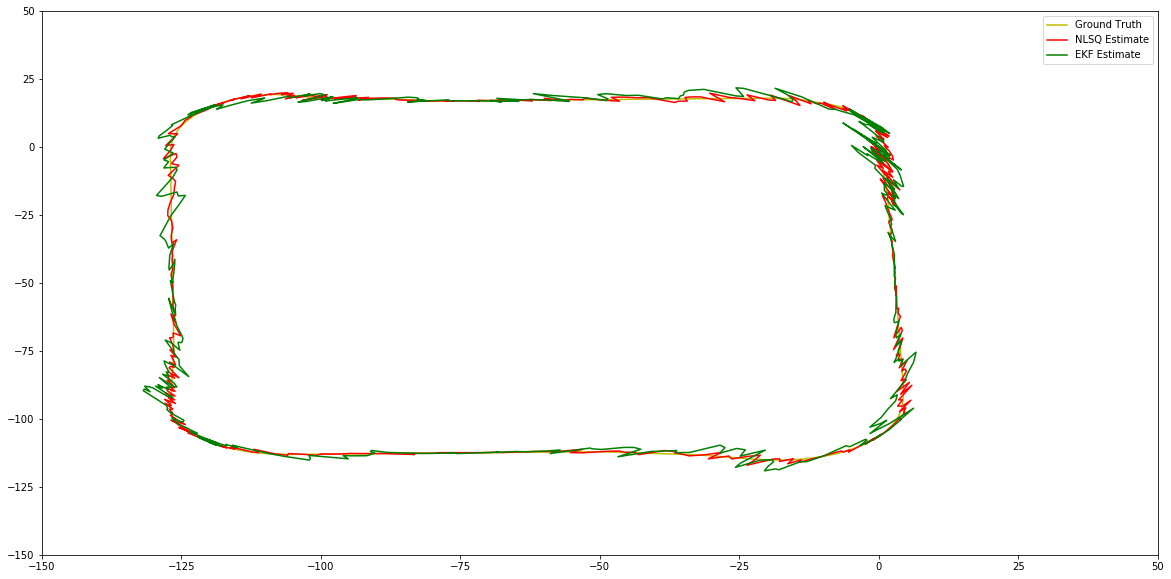

In [39]:
fig = plt.figure(figsize=(20,10))
plt.plot(gt_x,gt_y, "-y", label='Ground Truth')
plt.plot(xe,ye, "-r", label='NLSQ Estimate')
plt.plot(nl_arr[:,0], nl_arr[:,1], '-g',  label='EKF Estimate')
plt.legend()
plt.xlim([-150,50])
plt.ylim([-150,50])

In [27]:
sum_nlsq = 0
sum_ekf = 0
for i in range(0, gt_x.shape[0]):
    sum_nlsq = sum_nlsq + np.linalg.norm(np.array([gt_x[i], gt_y[i]])- X1_hat[i].transpose())
for i in range(0, nl_arr[:,0].shape[0]):
    sum_ekf = sum_ekf + np.linalg.norm(np.array([nl_arr[:,0][i], nl_arr[:,1][i]])- X1_hat[i].transpose())

print("Pose Error for NLSQ",sum_nlsq/gt_x.shape[0])
print("Pose Error for EKF",sum_ekf/nl_arr[:,0].shape[0])

Pose Error for NLSQ 1.1749525226012545
Pose Error for EKF 2.9826982667192374
